In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import re
import ast
# from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [2]:
# Load the artists data as a list type
generic = lambda x: ast.literal_eval(x)
conv = {'artists': generic}
df = pd.read_csv("data.csv", converters=conv)

In [3]:
df.shape

(174389, 19)

In [4]:
features = df.columns.drop(["id", "artists", "name"])

In [5]:
X_data, target = df[features], df["artists"]

In [6]:
X_data.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,0.598,168333,0.224,0,0.000522,5,0.3790,-12.628,0,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,0.852,150200,0.517,0,0.026400,5,0.0809,-7.261,0,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,0.647,163827,0.186,0,0.000018,0,0.5190,-12.098,1,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,0.730,422087,0.798,0,0.801000,2,0.1280,-7.311,1,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,0.704,165224,0.707,1,0.000246,10,0.4020,-6.036,0,2,1920-10-01,0.0768,122.076,0.2990,1920


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_data, target, test_size=0.2, random_state=1)

## Missing values

In [8]:
df.isnull().sum()

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64

## Variable types

In [9]:
df.dtypes

acousticness        float64
artists              object
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
valence             float64
year                  int64
dtype: object

## Output space exploratory analysis (distribution of the register over the classes)

In [10]:
artists_by_register_count = df["artists"].apply(lambda x: len(x))

In [11]:
print("Maximum number of artists on a single register: {}".format(artists_by_register_count.max()))

Maximum number of artists on a single register: 28


In [12]:
# Get all posible values
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [13]:
artist_count = to_1D(target).value_counts()

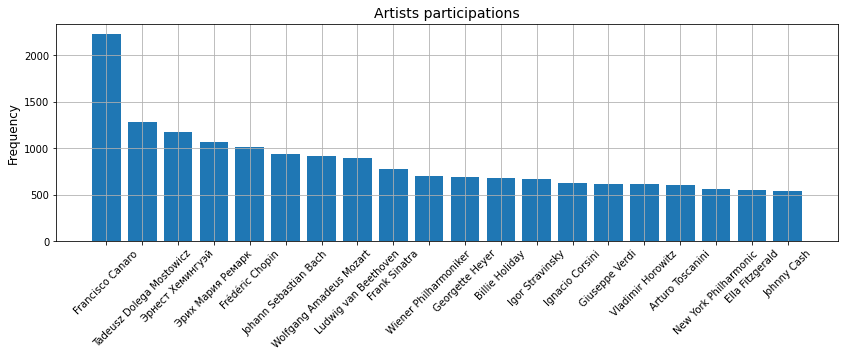

In [14]:
fig, ax = plt.subplots(figsize = (14,4))
ax.bar(artist_count.iloc[0:20].index,
        artist_count.iloc[0:20].values)

ax.set_ylabel("Frequency", size = 12)
ax.set_title("Artists participations", size = 14)
ax.grid(True)
plt.xticks(rotation=45)
plt.show()

#### Some of the artists are novelists, so we can infer that in their case are audiobooks fragments

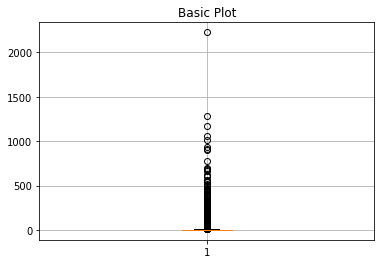

In [15]:
fig, ax = plt.subplots()
ax.set_title('Basic Plot')
ax.boxplot(artist_count)
ax.grid(True)
plt.show()

In [16]:
artist_count.describe()

count    32540.000000
mean         7.202581
std         31.239301
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       2228.000000
dtype: float64

In [17]:
print("Proportion of classes with only one sample: {}".format((artist_count==1).sum() / len(artist_count)))

Proportion of classes with only one sample: 0.4804240934234788


In [18]:
artist_count.quantile(q=0.8)

6.0

In [19]:
(artist_count<2).sum() / len(artist_count)

0.4804240934234788

In [20]:
(artist_count<5).sum() / len(artist_count)

0.7649661954517517

#### 48% of the classes have only one sample on the dataset and around 80% have less than 6 samples.

In [21]:
artist_count

Francisco Canaro                      2228
Tadeusz Dolega Mostowicz              1281
Эрнест Хемингуэй                      1175
Эрих Мария Ремарк                     1062
Frédéric Chopin                       1013
                                      ... 
Steve Lieberman, The Gangsta Rabbi       1
Frederic Riesterer                       1
James Sanderson                          1
KLIMT WESTWOOD                           1
John Georgiadis                          1
Length: 32540, dtype: int64

There are repeated labels?

In [22]:
artist_count.index.nunique()

32540

In [23]:
artist_count.index.str.lower().nunique()

32515

25 repeated artists names

In [24]:
all_artists = artist_count.index.str.lower().unique()

In [25]:
duplicated_artists = artist_count[artist_count.index.str.lower().duplicated()]

In [26]:
duplicated_artists.index

Index(['SIVAN', 'RANI', 'Kyle', 'KARRA', 'iRO', 'Nero', 'KAI', 'ALI', 'Dino',
       'FISHER', 'Oxxyo', 'LUNA', 'ENZO', 'kai', 'RAJAN', 'Otto Von Rohr',
       'MAKO', 'FLAME', 'Icehouse', 'Lolo', 'RUN', 'CHUCK', 'Aether', 'Liz',
       'StoneBlue'],
      dtype='object')

In [27]:
artist_count

Francisco Canaro                      2228
Tadeusz Dolega Mostowicz              1281
Эрнест Хемингуэй                      1175
Эрих Мария Ремарк                     1062
Frédéric Chopin                       1013
                                      ... 
Steve Lieberman, The Gangsta Rabbi       1
Frederic Riesterer                       1
James Sanderson                          1
KLIMT WESTWOOD                           1
John Georgiadis                          1
Length: 32540, dtype: int64

In [28]:
artists_count_non_dup = artist_count.index.str.lower().unique()

In [29]:
target_lower = target.copy()

In [30]:
target_lower = target_lower.apply(lambda x: [i.lower() for i in x])

In [31]:
target_lower

0                        [mamie smith]
1              [screamin' jay hawkins]
2                        [mamie smith]
3                    [oscar velazquez]
4                               [mixe]
                      ...             
174384    [dj combo, sander-7, tony t]
174385                  [alessia cara]
174386                     [roger fly]
174387                  [taylor swift]
174388                     [roger fly]
Name: artists, Length: 174389, dtype: object

Are there artists with their names on different languages?

For example, эрнест хемингуэй is ernest hemingway

In [32]:
artists_count_non_dup[0:30]

Index(['francisco canaro', 'tadeusz dolega mostowicz', 'эрнест хемингуэй',
       'эрих мария ремарк', 'frédéric chopin', 'johann sebastian bach',
       'wolfgang amadeus mozart', 'ludwig van beethoven', 'frank sinatra',
       'wiener philharmoniker', 'georgette heyer', 'billie holiday',
       'igor stravinsky', 'ignacio corsini', 'giuseppe verdi',
       'vladimir horowitz', 'arturo toscanini', 'new york philharmonic',
       'ella fitzgerald', 'johnny cash', 'lata mangeshkar', 'elvis presley',
       'miles davis', 'bob dylan', 'charlo', 'the rolling stones',
       'fleetwood mac', 'the beach boys', 'leonard bernstein', 'dean martin'],
      dtype='object')

In [33]:
artists_count_non_dup[artists_count_non_dup.str.startswith("ernest")]

Index(['ernesto fama', 'ernest ansermet', 'ernest bloch', 'ernest hemingway',
       'ernesto bassignano', 'ernest tubb', 'ernest lush', 'ernest chausson',
       'ernesto dominici', 'ernestine anderson', 'ernest macmillan',
       'ernesto vs. bastian', 'ernest ranglin', 'ernesto bonino',
       'ernest gold', 'ernesto decurtis', 'ernesto tagliaferri',
       'ernest lehman', 'ernest kohl', 'ernest ashworth', 'ernesto nazareth',
       'ernesto lecuona', 'ernesto de curtis', 'ernesto martins', 'ernesto',
       'ernest moret', 'ernest truex'],
      dtype='object')

In [34]:
artists_count_non_dup[artists_count_non_dup.str.endswith("presley")]

Index(['elvis presley'], dtype='object')

Are there any very similar strings between them?

- johnny nash, 'jonny nash'
- 

Are there artists that does not separe by comma? like / or others?

In [35]:
regex = "[a-z]/[A-Z]"

In [36]:
index_filter = target.astype(str).str.contains(regex, regex=True)

In [37]:
index_filter

0         False
1         False
2         False
3         False
4         False
          ...  
174384    False
174385    False
174386    False
174387    False
174388    False
Name: artists, Length: 174389, dtype: bool

In [38]:
def split_slash(x):
    all_artists = []
    for i in x:
        all_artists = all_artists + i.split("/")
    return all_artists

In [39]:
target_lower[index_filter] = target_lower[index_filter].apply(lambda x: split_slash(x))

In [40]:
target_lower

0                        [mamie smith]
1              [screamin' jay hawkins]
2                        [mamie smith]
3                    [oscar velazquez]
4                               [mixe]
                      ...             
174384    [dj combo, sander-7, tony t]
174385                  [alessia cara]
174386                     [roger fly]
174387                  [taylor swift]
174388                     [roger fly]
Name: artists, Length: 174389, dtype: object

In [41]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer

In [42]:
all_artists_list = to_1D(target_lower)

In [43]:
all_artists_list

0                   mamie smith
1         screamin' jay hawkins
2                   mamie smith
3               oscar velazquez
4                          mixe
                  ...          
234916                   tony t
234917             alessia cara
234918                roger fly
234919             taylor swift
234920                roger fly
Length: 234921, dtype: object

### Discard classes with only 2 instances (for the sake of output dimensionality)

In [44]:
all_artists_list

0                   mamie smith
1         screamin' jay hawkins
2                   mamie smith
3               oscar velazquez
4                          mixe
                  ...          
234916                   tony t
234917             alessia cara
234918                roger fly
234919             taylor swift
234920                roger fly
Length: 234921, dtype: object

In [45]:
def drop_artists_low_aparition(x, artists_to_discard):
    for artist in artists_to_discard.index.to_list():
        if artist in x:
            x.remove(artist)
    return x

In [46]:
split_index = (to_1D(target_lower).value_counts() > 2).sum()

In [47]:
artists_to_discard = to_1D(target_lower).value_counts()[split_index::]

In [48]:
# Remove all classes with just one instance
target_filtered = target_lower.apply(lambda x: drop_artists_low_aparition(x, artists_to_discard))

In [49]:
index_to_keep = target_filtered[target_filtered.apply(lambda x: len(x)) > 0].index.to_list()

In [50]:
target_filtered = target_filtered[target_filtered.apply(lambda x: len(x)) > 0]

In [51]:
X_data = X_data[X_data.index.isin(index_to_keep)]

In [52]:
X_data.shape, target_filtered.shape

((159068, 16), (159068,))

Only 11694 different labels are mantain.

## Feature Engineering

### Datetime manipulation (release date)

How many samples have a the month and day of the month in it?

In [53]:
(X_data["release_date"].str.split("-").apply(lambda x: len(x)) > 1).value_counts().values / len(X_data)

array([0.69790907, 0.30209093])

Approx 30% percent of data don't have them, so, let's not add them to the dataset.

In [54]:
X_data.drop(columns="release_date", inplace=True)

In [57]:
X_data.shape, target_filtered.shape

((159068, 15), (159068,))

## Feature selection

__Pipeline of feature selection:__

- Remove __quasi-constant features__ (features with variance less than certain threshold, both categorical and numerical)
- Remove __duplicated features__ (features with the same values)
- Remove __highly correlated__ features among themselves (keep features highly correlated with the target yet uncorrelated among them). This helps too to prevent misleading coeficients of importance when trees ensembling models are fitted.
    - Hypothesis: speechiness and instrumentalness, loudness and energy are correlated
- Remove other non-discriminative features using Embedded methods (leveraging the use of tree emsenble methods like random forest) and Wrapper methods (forward and backward)

In [58]:
import seaborn as sns

Pearson correlation coeficient (lineal relationship)

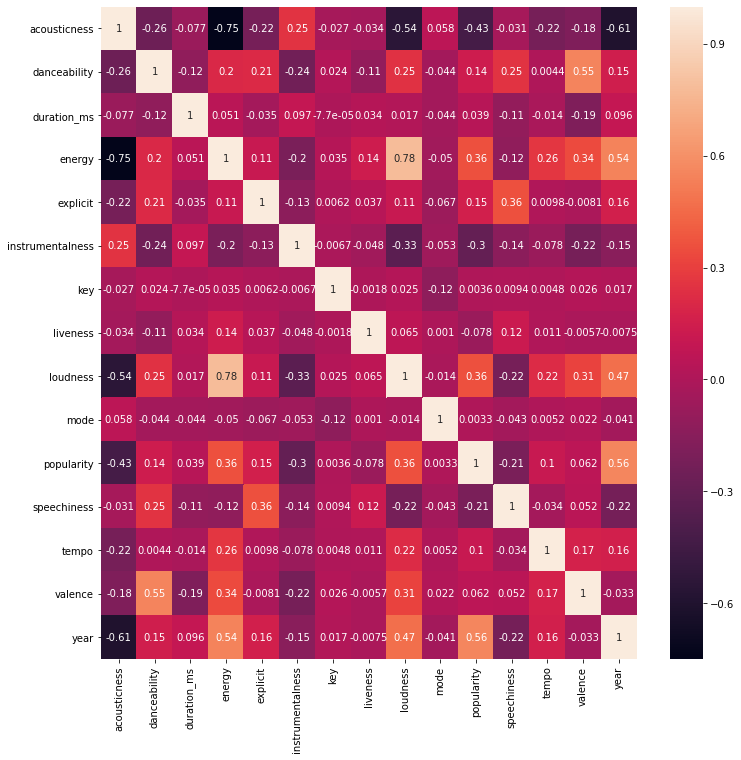

In [59]:
corrmat = X_data.corr(method="pearson")
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
sns.heatmap(corrmat, annot = True)
plt.show()

Some variables as expected are highly correlated like: 

- loudness and energy __(0.779267)__
- acousticness and energy __(-0.750852)__
- year and acousticness __(-0.607515)__ 

__Methods for eliminate highly correlated features__

__Brute force__: Determine correlation between a selected feature and every other. If the feature is highly correlated, drop it. __Problem__: This can lead to eliminate better features.

__Grouping__:

    1. Identify groups of correlated features.
    2. Select the feature with higher predictive power (train a ml model on each group and select the best feature, or keep the feature with the less number of missing values)
    3. Discard the rest

In [60]:
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection, DropConstantFeatures, DropDuplicateFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

In [61]:
# Values for the feature selection
random_state_split = 42
constant_feat_tolerance = 0.92
correlation_threshold = 0.75
correlation_method = "pearson"

In [62]:
correlation_approach = DropCorrelatedFeatures(
    method=correlation_method,
    threshold=correlation_threshold,
)

In [63]:
feat_sel_pipeline = Pipeline([
    ("quasi-constant", DropConstantFeatures(tol=constant_feat_tolerance)),
    ("duplicated", DropDuplicateFeatures()),
    ("correlation", correlation_approach)
])

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_data, target_filtered, test_size=0.2, random_state=random_state_split)

In [67]:
feat_sel_pipeline.fit(X_train, y_train)

Pipeline(steps=[('quasi-constant',
                 DropConstantFeatures(tol=0.92,
                                      variables=['acousticness', 'danceability',
                                                 'duration_ms', 'energy',
                                                 'explicit', 'instrumentalness',
                                                 'key', 'liveness', 'loudness',
                                                 'mode', 'popularity',
                                                 'speechiness', 'tempo',
                                                 'valence', 'year'])),
                ('duplicated',
                 DropDuplicateFeatures(variables=['acousticness',
                                                  'danceability', 'duration_ms',
                                                  'energy', 'instrumentalness',
                                                  'key', 'liveness', 'loudness',
                                               

In [72]:
print("quasiconstant features: {}".format(feat_sel_pipeline[0].features_to_drop_))

quasiconstant features: ['explicit']


In [69]:
print("duplicated features: {}".format(feat_sel_pipeline[1].features_to_drop_)

set()

In [74]:
print("highly correlated features: {}".format(feat_sel_pipeline[2].features_to_drop_))

highly correlated features: {'energy'}


In [75]:
feat_sel_pipeline[2].correlated_feature_sets_

[{'acousticness', 'energy'}]

In [77]:
X_train = feat_sel_pipeline.transform(X_train)
X_test = feat_sel_pipeline.transform(X_test)

In [80]:
X_train.shape, X_test.shape

((127254, 13), (31814, 13))

### Only 13 features remain

In [90]:
X_data_final = pd.concat([X_train, X_test]).reset_index(drop=True)

In [81]:
target_filtered

0                           [mamie smith]
1                 [screamin' jay hawkins]
2                           [mamie smith]
3                       [oscar velazquez]
5         [mamie smith & her jazz hounds]
                       ...               
174384       [dj combo, sander-7, tony t]
174385                     [alessia cara]
174386                        [roger fly]
174387                     [taylor swift]
174388                        [roger fly]
Name: artists, Length: 159068, dtype: object

In [99]:
X_data_final.to_csv("preprocessed/X_data.csv", index=False)

In [100]:
target_filtered.to_csv("preprocessed/target.csv", index=False)

## Feature scaling (not needed for tree based methods)



- acousticness (Ranges from 0 to 1)
- danceability (Ranges from 0 to 1)
- energy (Ranges from 0 to 1)
- duration_ms (Integer typically ranging from 200k to 300k)
- instrumentalness (Ranges from 0 to 1)
- valence (Ranges from 0 to 1)
- popularity (Ranges from 0 to 100)
- tempo (Float typically ranging from 50 to 150)
- liveness (Ranges from 0 to 1)
- loudness (Float typically ranging from -60 to 0)
- speechiness (Ranges from 0 to 1)
- year (Ranges from 1921 to 2020)


## Scaling variables

In [79]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()